 ## XFOIL analysis with python UI
 
 #### we set the control point has 6 on top edge, 6 on the bottom
 
 below is the index that has to be fixed, when calling the mutation function, those two points has fixed x aixs
     
     index_fix = [6]
 
 ### index

* [init](#init): initial and refresh the program
* [Bezier curve](#bezier curve): the function that builds airfoil using control points using bezier curves
* [Generator](#generator): this is to generate new airfoil using reproduction and mutation
* [File and Data Mining](#mining): this is to mine the data from files
* [Heuristic Function](#eva): the algorithm of evaluation function
* [Script](#script): couple xfoil and compose the script for calculation
* [Run](#run): execute

---
<a id='init'></a>
## init

In [1]:
import subprocess as sp
import shutil
import sys
import string
import shutil
from os.path import isfile, join
from os import listdir
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def data_check(cl):
    if max(cl) < 1.4:
        return True
    else:
        return False
    
def frange(start, finish, interval=1.0):
    #frange starts from small angle to large angle
    assert finish > start, 'frange start with smaller number'
    x = float(start)
    out = [x]
    while x < float(finish):
        x+=interval
        out.append(round(x, 5))
    #make sure that the last element is the finish value
    out = list(set(out[:-1] + [float(finish)]))
    #list element is from small to large
    return sorted(out)

def file2cor(file):
    '''this is to get the airfoil cordinates in list'''
    f = list(open(file, 'r'))
    # get rid of \n term and space
    cordinate = [(i.split('\n')[0]).split(' ') for i in f]
    cordinate = [list(filter(lambda x: len(x) > 0, cor)) for cor in cordinate]
    cordinate = [list(map(float, row)) for row in cordinate]
    #therefore this becomes [[x1, y1], [x2, y2], [x3, y3] ...]

    return cordinate

In [3]:
import os
from pathlib import Path
import sched, time
def boostup(data_loc, airfoil_loc):
    '''this is to restart the program by erasing all the files and datas from previous calculation'''
    p = Path(data_loc)
    #if the directory is there, delete it
    if p.is_dir():
        shutil.rmtree(data_loc)
    #when the directory is still ther, sleep
    while p.is_dir():
        time.sleep(2)
    #create da directory
    os.makedirs(data_loc)
    
    #get the list of dir in a path
    f = Path(airfoil_loc)
    #if the directory is there, delete it
    if f.is_dir():
        shutil.rmtree(airfoil_loc)
    #when the directory is still ther, sleep
    while f.is_dir():
        time.sleep(2)
    #create da directory
    os.makedirs(airfoil_loc)
    pass

In [26]:
def ctlPts_setup(n_foil):

    #setup the original control points using interpolation
    upperX = lowerX = frange(0, 1, 1/4)
    #get the airfoil coordiante
    origin = file2cor('backup/FX84-218.txt')
    zero = origin.index([0.0,0.0])
    genesUp = (origin[:zero])[::-1]
    genesDown = (origin[zero+1:])
    
    upX = [i[0] for i in genesUp]
    upY = [i[1] for i in genesUp]
    tck = interpolate.splrep(upX, upY, s=0)
    upperY = interpolate.splev(upperX, tck, der=0)
    upper = list(zip(upperX, upperY))
    upper = [list(i) for i in upper]

    downX = [i[0] for i in genesDown]
    downY = [i[1] for i in genesDown]
    tck = interpolate.splrep(downX, downY, s=0)
    lowerY = interpolate.splev(lowerX, tck, der=0)
    lower = list(zip(lowerX, lowerY))
    lower = [list(i) for i in lower]
    
    #initial contral points
    ctlPts = [upper[::-1], lower]

    foils = {str(n): ctlPts_generator(ctlPts) for n in range(n_foil-1)}
    foils.update({str(n_foil-1): ctlPts})
    #foils = {foil index: control points setup}
    return foils
    
def ctlPts_generator(ctlPts):
    '''generate control points and save the points in backup file'''
    #set an original airfoil then do some mutation
    #why this? to ensure no sharp leading edge
    ctlPts = mutation(ctlPts, 1)
    ctlPts[0][-1][1] += random.uniform(0.2, 0.8) / 500

    
    return ctlPts

In [70]:
ctlPts_setup(5)

{'0': [[[1.0, 0.0],
   [0.7500779851355893, 0.070963983985829815],
   [0.5003421351160571, 0.12976269713591668],
   [0.25011746788976974, 0.13711621706177346],
   [0.0, 0.09210748363412759]],
  [[0.0, -0.0059304794815987641],
   [0.24987196041781454, -0.080433361018673516],
   [0.5000898329380369, -0.065623621182567121],
   [0.7499286280860502, -0.034802437179666565],
   [1.0, 0.0]]],
 '1': [[[1.0, 0.0],
   [0.7500779851355893, 0.070963983985829815],
   [0.5003421351160571, 0.12976269713591668],
   [0.25011746788976974, 0.13711621706177346],
   [0.0, 0.09210748363412759]],
  [[0.0, -0.0059304794815987641],
   [0.24987196041781454, -0.080433361018673516],
   [0.5000898329380369, -0.065623621182567121],
   [0.7499286280860502, -0.034802437179666565],
   [1.0, 0.0]]],
 '2': [[[1.0, 0.0],
   [0.7500779851355893, 0.070963983985829815],
   [0.5003421351160571, 0.12976269713591668],
   [0.25011746788976974, 0.13711621706177346],
   [0.0, 0.09210748363412759]],
  [[0.0, -0.0059304794815987641]

---
<a id = 'bezier curve'></a>
## Bezier Curve

why bezier curve?
Since when we mutate cordinate file directly, sometimes it will causes crashes of xfoil, therefore using control points approach will have a nice airfoil no matter what

In [5]:
import numpy as np

#--- MAIN ---------------------------------------------------------------------+
def airfoil(loc, ctlPts, names, numPts, boo=True):
    '''this function is using bezier curve to produce airfoil from control points
    intput:   
        foil_locs: {airfoil name: cordinate location} 
        foil_ctlPts: {airfoil name: control points}
        foil_names: [airfoil names]
        numPts: number of points per bezier curve
        boo: should the file be saved (stupid parameter)
        
    '''
    ctlPts = ctlPts[0] + ctlPts[1]

    def quadraticBezier(t, points):
        #recreated the bezier curve formula
        B_x=(1-t)*((1-t)*points[0][0]+t*points[1][0])+t*((1-t)*points[1][0]+t*points[2][0])
        B_y=(1-t)*((1-t)*points[0][1]+t*points[1][1])+t*((1-t)*points[1][1]+t*points[2][1])
        return B_x,B_y

    curve=[]
    #construct the independent variable
    t=np.array([i*1/numPts for i in range(0,numPts)])

    # calculate first Bezier curve
    midX=(ctlPts[1][0]+ctlPts[2][0])/2
    midY=(ctlPts[1][1]+ctlPts[2][1])/2
    B_x0,B_y0=quadraticBezier(t,[ctlPts[0],ctlPts[1],[midX,midY]])
    curve=curve+list(zip(B_x0,B_y0))

    # calculate middle Bezier Curves
    for i in range(1,len(ctlPts)-3):
        p0=ctlPts[i]
        p1=ctlPts[i+1]
        p2=ctlPts[i+2]
        midX_1=(ctlPts[i][0]+ctlPts[i+1][0])/2
        midY_1=(ctlPts[i][1]+ctlPts[i+1][1])/2
        midX_2=(ctlPts[i+1][0]+ctlPts[i+2][0])/2
        midY_2=(ctlPts[i+1][1]+ctlPts[i+2][1])/2

        B_xi,B_yi=quadraticBezier(t,[[midX_1,midY_1],ctlPts[i+1],[midX_2,midY_2]])
        curve=curve+list(zip(B_xi,B_yi))

    # calculate last Bezier curve
    midX=(ctlPts[-3][0]+ctlPts[-2][0])/2
    midY=(ctlPts[-3][1]+ctlPts[-2][1])/2

    B_x1,B_y1=quadraticBezier(t,[[midX,midY],ctlPts[-2],ctlPts[-1]])
    curve=curve+list(zip(B_x1,B_y1))
    curve.append(ctlPts[-1])

    # write airfoil coordinates to text file
    if boo:
        xPts,yPts=zip(*curve)
        f=open(loc,'w+')
        for i in range(len(xPts)):
            f.write(str(xPts[i])+','+str(yPts[i])+'\n')
        f.close()
    
    pass
    

---
<a id='generator'></a>
## Generator

In [6]:
import itertools as it
def generator(loc, parents_ctlPts, mut_inten, gen):
    '''
    input:
        loc: the dir that where we save the airfoil cordinates
        parents_ctlPts: {airfoil name: cordinates}
        mut_inten = mutation intensity
        gen = which generation
    output:
        foil_locs: {airfoil name: cordinate location} 
        foil_ctlPts: {airfoil name: control points}
        foil_names: [airfoil names]
    '''
    #gen name
    surname = 'G'+str(gen).zfill(2)
    #airfoil name
    n_foil = 0
    first_name = 'A{}'.format
    
    foil_ctlPts = {}
    foil_locs = {}
    foil_names = []
    
    #generate all the possible combinations
    couples = list(it.combinations(list(parents_ctlPts.keys()), 2))
    for father, mother in couples:
        #papa and mama produce some children
        try:
            child1, child2 = reproduction(parents_ctlPts[father], parents_ctlPts[mother], mut_inten)
        except:
            print(father, mother)

        #get airfoil serial number and put them into dictionary
        n_foil+=1
        name = surname+first_name(n_foil)
        foil_names.append(name)
        Floc = loc+name+'.txt'
        foil_locs[name] = Floc
        foil_ctlPts[name] = child1
                
        n_foil+=1
        name = surname+first_name(n_foil)
        foil_names.append(name)
        Floc = loc+name+'.txt'
        foil_locs[name] = Floc
        foil_ctlPts[name] = child2
    
    for name in foil_names:
        ctlPts = foil_ctlPts[name]
        loc = foil_locs[name]
        #build airfoil cordinate using bezier curve
        airfoil(loc, ctlPts, name, 20)
    
    return foil_locs, foil_ctlPts, foil_names

def reproduction(father, mother, mutation_intensity):
    

    #split genes
    genesUp = [father[0], mother[0]]
    genesDown = [father[1], mother[1]]
    
    #new airfoil
    child1 = [genesUp[0], genesDown[1]]
    child2 = [genesUp[1], genesDown[0]]
    
    #make sure they are in good formate fist and last are [1.0, 0.0]
    child1 = mutation(child1, mutation_intensity)
    child2 = mutation(child2, mutation_intensity)
    
    return child1, child2

In [30]:
def mutation(ctlPts, mut_intens):
    '''this function is to radomize control points locations
        ctlPts: contral points example [[top edge points], [bottom edge points]]
        mut_intens : the probability that the point will be changed
    '''

    for Pts in range(len(ctlPts)):     
        for i in range(len(ctlPts[Pts])):
            if float(random.randint(0,100)) < mut_intens * 100:
                #change x_axis
                #keep the minimum x_axis value higher than or equal to 0
                ctlPts[Pts][i][0] += random.uniform(-6.0,6.0) / 1000
                while round(ctlPts[Pts][i][0], 3) < 0.0:
                    ctlPts[Pts][i][0] += random.uniform(-1,1) / 600
                #change y_axis
                ctlPts[Pts][i][1] += random.uniform(-1.0, 1.0) / 1000
    
    #keep the first point and the last point as [1.0, 0.0]
    ctlPts[0][0] = ctlPts[1][-1] = [1.0, 0.0]
    #keep the middle point as 0.0
    ctlPts[0][-1][0] = ctlPts[1][0][0] = 0.0
    #no niddle edge
    while ctlPts[0][-1][1] < 0.05:
        ctlPts[0][-1][1] = random.uniform(0.07, 0.09)
    #top edge, control points x-axis from large to small
    ctlPts[0] = sorted(ctlPts[0], reverse=True)
    #bottom edge, control points x-axis from small to large
    ctlPts[1] = sorted(ctlPts[1])
    
    #return : [[top edge], [bottom edge]]
    return ctlPts

---
<a id='mining'></a>
## File and Data Mining

In [8]:
from os import listdir


def foil_mining(airfoil_loc):
    #get only the files in a directory 
    #if boo=True, only get files, if boo=False
    file_list = [f for f in listdir(airfoil_loc)]
    # get only the airfoil name
    for f in file_list:
        yield f.split('.')[0]

def file_mining(file):
    #open file and convert them into list
    f = list(open(file, 'r'))
    #only select those data (need to be test if there is a buy)
    f = f[12:]
    #contains a list contains all the [alpha, CL]
    output = [i.split()[:2] for i in f]
    #since now output value elements are string, we need to con conver them to float
    output = [list(map(float, row)) for row in output]
    return output

def data_mining(data_loc,reys):
    #make the data directory of the airfoil
    airfoils = foil_mining(data_loc)
    for airfoil in airfoils:
        loc = data_loc+airfoil+'/'
        outputs = []
        #use foil mining function to mine reynolds number
        reys = foil_mining(loc)
        for rey in reys:
            #get the output for each reynolds number
            output = file_mining(loc+str(rey)+'.txt')
            #put rey data with angle value
            outputs.append([rey,output])
            #example: [rey, [*angle, *cl, *cd]]
        yield airfoil, outputs

---
<a id='eva'></a>
## Heuristic Function

In [75]:
def weight(x):
    #weights = 10 * sigmoid((x-4) / 2.5) + 0.01
    weights = 10 * sigmoid((x-10)) + 0.01
    return weights

In [133]:
import numpy as np
def heuristic(mata_data, gen):
    #contains: airfoil info, rey, angles, data
    #for each reynolds number
    final_score = {}
    for airfoil, data in mata_data:
        #data [angle, cl]
        score = 0
        for i in data:
            #get score for the each reynolds number
            angleP = heuristic_angle(i[1], gen)
            #weight them by different reynolds number
            reyP = heuristic_rey(i[0])
            #sum them up
            score += angleP * reyP
            score = float('%.3f' % round(score, 3))
            
        final_score.update({airfoil: score})
    return final_score

def heuristic_rey(rey):
    #haven't decide the model yet!!!!!
    '''need to discuss this'''
    return 1

def heuristic_angle(datas, gen):
    #set initial point
    final_point = 0
    if datas:
        #let only the higher angle of attack generating scores,, so solve the problem
        data = np.transpose(datas)
        ind = np.argwhere(data[0]>9)
        data = data[:, ind]
        #use costumized sigmoid function to get weights
        ## mainly to enhance the importance of the Cls above 8 degree AOT
        weights = weight(data[0])

        #get the score for each angle
        points = data[1] * weights
        #positive all the negative term
        points = np.sqrt(points**2)
        #averge them and times 10
        final_point = np.average(points) * 10
    else:
        pass
    #only output the score up to 3 decimal places
    return final_point

because I am using average score, so there are false airfoil generated, they don't converge lower angle and only converge on higher angle

In [126]:
lan_angle= angle_range
lan = np.array([lan_angle, lan_angle])
l = np.argwhere(lan[0]>13)
lan = lan[:, l]
type(lan)

numpy.ndarray

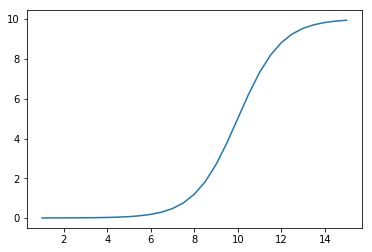

In [91]:

x = np.array(frange(1, 15, 0.5))
w = weight(x)
plt.plot(x, w)
plt.show()

In [93]:
w

array([ 0.01123395,  0.01203427,  0.0133535 ,  0.01552779,  0.01911051,
        0.02501182,  0.03472623,  0.05070138,  0.07692851,  0.11986943,
        0.1898621 ,  0.30312231,  0.48425873,  0.7685818 ,  1.20202922,
        1.83425524,  2.69941421,  3.78540669,  5.01      ,  6.23459331,
        7.32058579,  8.18574476,  8.81797078,  9.2514182 ,  9.53574127,
        9.71687769,  9.8301379 ,  9.90013057,  9.94307149])

In [12]:
import operator
def sort_airfoil(data, old_champs=[]):
    #sort airfoil according to score from big to small
    candidates = list(data.items())
    candidates += old_champs
    return (sorted(candidates, key=operator.itemgetter(1), reverse=True))

---
<a id='script'></a>
## Script

In [13]:
def availability(airfoil_loc):    
    # here we could check the Cl difference when running filt, if difference is too large, the airfoil is not available
    pro = ps.Popen(['xfoil.exe'],    
                stdin=sp.PIPE,                  
                stdout=sp.PIPE,                  
                stderr=None,                  
                encoding='utf8')       
    #execute the script   
    script = ['load '+'airfoil/1gen/g01a1.txt', 
              'airfoil',
              'MDES',
              'FILT\n']
    res = pro.communicate('\n'.join(script))
    
        #get the thickness index of the airfoil
    result_text = list(filter(None, str(res[0]).split(' ')))
    #find two different Cl
    result_text = result_text[-30:]
    Cl = [result_text[i+2] for i in range(len(result_text)) if result_text[i] == 'CL']
    ratio = 100 * abs(float(Cl[0]) - float(Cl[0])) / float(Cl[0])
    #what this ratio?
    if ratio >= 0.2:
        return False
    else:
        return True

In [20]:
import psutil as ps

def script(airfoil_loc, airfoil, data_loc, AOT, RE):
    load_script = ['load '+airfoil_loc, 
            airfoil,
            'MDES',
            'filt',
            'EXEC',
            ' ',
            'PANE',
            'OPER',
            'ITER 150']       
    #define the output file name (different reynolds number has different file)
    data_file_name = data_loc+'/'+str(RE)+'.txt'
    #check and create file
    constant_set = ['RE ' + str(RE),
                    'VISC ' +str(RE),
                    'PACC', 
                    data_file_name,
                    ' ']
    #analyse different angle of attack
    alpha = ['ALFA '+str(a) for a in AOT]
    init = constant_set + alpha + ['PACC', ' ',]
    load_script += init
    load_script += [' ', ' ', 'QUIT\n']
    return load_script

In [21]:
def execute(airfoil_loc, airfoil, data_loc, angles, rey_range, boo):
    #create a directory for each airfoil
    filedir = data_loc+airfoil
    if not os.path.isdir(filedir):
        os.makedirs(filedir)
    if boo:
        for RE in rey_range:
            #coupling xfoil into python
            if not isfile(filedir+'/'+str(RE)+'.txt'):
                pro = ps.Popen(['xfoil.exe'],
                              stdin=sp.PIPE,
                              stdout=None,
                              stderr=None,
                              encoding='utf8')
                #execute the script
                res = pro.communicate('\n'.join(script(airfoil_loc,airfoil, filedir, angle_range, RE)))


In [22]:
def thickness(airfoil_loc, min_thick):
    '''this is to check if the airfoil have sufficient thickness'''
    pro = ps.Popen(['xfoil.exe'],    
                  stdin=sp.PIPE,                  
                  stdout=sp.PIPE,                  
                  stderr=None,                  
                  encoding='utf8')       
    #execute the script   
    res = pro.communicate('\n'.join(['load '+airfoil_loc, 'airfoil\n']))
    
    #get the thickness index of the airfoil
    result_text = list(filter(None, str(res[0]).split(' ')))
    thickness_loc = result_text.index('thickness') + 2
    thickness = float(result_text[thickness_loc])
    
    weight = thickness / min_thick
    if float(weight) > 1.0:
        weight = 1.0
    return weight

---
<a id='run'></a>
## Run

In [134]:
#constants setting
epochs = 100
airfoil_dir = 'airfoil/'
data_dir = 'data/'
#'why do we choose this angle of attack'
angle_range = frange(0, 13.5, 0.1)
#'how to get this value?'
rey_range = [200000]
n_parents = 5
mut_inten = 0.5
#"control points shouldn't be too many"

In [135]:
#reboot
boostup(data_dir, airfoil_dir)

In [ ]:
from tqdm import tqdm_notebook

parents_names = [] #parents' names
parents_ctlPts = {} #{names: control points}
parents_loc = {} #{names: cordinate locations}
parents_scores = [] # [(airfoil names, scores)]
last_MVA = ''

#set control points
cntPts = ctlPts_setup(n_parents)
#return: {name: cntPts}
parents_ctlPts.update(cntPts)

#set up most valuable airfoil list for each generation
record = open('airfoil/MVA.txt', 'w+')
record.write('---\n')
record.close()

#run the loop
for n in tqdm_notebook(range(epochs), desc='epochs'):
    #set generation
    gen = str(n+1)
    #set airfoil and data directory
    data_loc = data_dir+str(gen)+'gen/'
    airfoil_loc = airfoil_dir+str(gen)+'gen/'

    #create airfoil dir and data dir
    os.makedirs(data_loc)
    os.makedirs(airfoil_loc)

#'foil stage'    
    #generate airfoil cord"inate
    foil_locs, foil_ctlPts, foil_names= generator(airfoil_loc, parents_ctlPts, mut_inten, gen)
    #foil_locs = {names, locations}, foil_ctlPts = {names, control points}, foil_names = [airfoil names]

    for Fname in tqdm_notebook(foil_names, desc='airfoil', leave=False):
        airfoil_loc = foil_locs[Fname]
        boo = availability(airfoil_loc)
        execute(airfoil_loc, Fname, data_loc, angle_range, rey_range, boo)
        #load airfoil from airfoil_loc and use xfoil compute the necessary values nad dump data into data_loc

    #get lift coefficient of each angle in each reynolds number
    mata_data = data_mining(data_loc, rey_range)
    #mata_data = [airfoiil name [*rey, [*angle, *Cl]]]

    # basically, the winners will be reused in the next generation for comparation see if the next generation got better
    #get the scores in such order than the highers one is the first one
    #we can see, here, the last gen winner will be comparing with this gen data as well
    foil_scores = heuristic(mata_data, n)
    #foil_scores = {airfoil name: score}

    #check if the airfoil is thick enough
    # below 20%, the score will times the ration of thickness/minimum thickness
    for Fname in foil_scores.keys():
        w = thickness(foil_locs[Fname], 0.2)
        foil_scores[Fname] = w * foil_scores[Fname]

#'choose parents'
    #foil_scores = {airfoil names: scores}
    rank = sort_airfoil(foil_scores, parents_scores)
    #rank = [(airfoil name*, scores*)]


    # choose the number of parents in this model
    parents_scores = rank[:n_parents]
    parents_names = [i for i, _ in parents_scores]    

    #update the parents' location in dict formate
    #update the new parents airfoil locations
    parents_loc.update({Fname: foil_locs[Fname] for Fname in parents_names if Fname not in parents_loc})
    #filt the parents that are no longer good enough
    parents_loc = {Fname: parents_loc[Fname] for Fname in parents_names}

    #update the parents' control points
    #update the new parents airfoil control points
    parents_ctlPts.update({Fname: foil_ctlPts[Fname] for Fname in parents_names if Fname not in parents_ctlPts})
    #filt the parents that are no longer good enough
    parents_ctlPts = {Fname: parents_ctlPts[Fname] for Fname in parents_names}

    #choose the MVA most valuable airfoil and write the name to a file
    MVA_name = str(rank[0][0])
    #+1 if last MVA is the same as this one
    if MVA_name == last_MVA:
        count += 1
    else:
        count = 0
    print(MVA_name, count)
    last_MVA = MVA_name
    MVA_loc = str(parents_loc[MVA_name])
    MVA_score = str(parents_scores[0][1])
    stuff = MVA_name + ', '+MVA_loc+' '+MVA_score+ '\n'
    record = open('airfoil/MVA.txt', 'a')
    record.write(stuff)

    #if the MVA is the same in the consistant 10 generation. stop the program
    if count == 50:
        break
    record.close()


HBox(children=(IntProgress(value=0, description='epochs'), HTML(value='')))

HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 0


HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 1


HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 2


HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 3


HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 4


HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 5


HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 6


HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 7


HBox(children=(IntProgress(value=0, description='airfoil', max=20), HTML(value='')))

G01A11 8


In [120]:
data_loc = data_dir+str(0)+'gen/'
execute('backup/FX84-218.txt', 'fx84', data_loc, angle_range, rey_range, True)


In [130]:
mata_data = data_mining(data_loc, rey_range)
foil_scores = heuristic(mata_data, n)

[[[  9.1   ]
  [  9.2   ]
  [  9.3   ]
  [  9.4   ]
  [  9.5   ]
  [  9.6   ]
  [  9.7   ]
  [  9.8   ]
  [  9.9   ]
  [ 10.    ]
  [ 10.1   ]
  [ 10.2   ]
  [ 10.3   ]
  [ 10.4   ]
  [ 10.5   ]
  [ 10.6   ]
  [ 10.7   ]
  [ 10.8   ]
  [ 10.9   ]
  [ 11.    ]
  [ 11.1   ]
  [ 11.2   ]
  [ 11.3   ]
  [ 11.4   ]
  [ 11.5   ]
  [ 11.6   ]
  [ 11.7   ]
  [ 11.8   ]
  [ 11.9   ]
  [ 12.    ]
  [ 12.1   ]
  [ 12.2   ]
  [ 12.3   ]
  [ 12.4   ]
  [ 12.5   ]
  [ 12.6   ]
  [ 12.7   ]
  [ 12.8   ]
  [ 12.9   ]
  [ 13.    ]
  [ 13.1   ]
  [ 13.2   ]
  [ 13.3   ]
  [ 13.4   ]
  [ 13.5   ]]

 [[  1.1401]
  [  1.1479]
  [  1.1598]
  [  1.1754]
  [  1.1948]
  [  1.1814]
  [  1.1769]
  [  1.179 ]
  [  1.1857]
  [  1.1964]
  [  1.2114]
  [  1.2301]
  [  1.2174]
  [  1.2138]
  [  1.2155]
  [  1.2221]
  [  1.2325]
  [  1.2501]
  [  1.2525]
  [  1.2443]
  [  1.243 ]
  [  1.2469]
  [  1.2548]
  [  1.2703]
  [  1.2758]
  [  1.2673]
  [  1.2649]
  [  1.2677]
  [  1.2759]
  [  1.292 ]
  [  1.2895]
  [  1.283

In [96]:
foil_scores

{'G16A7': 279.122, 'fx84': 447.771}

In [102]:
foil_scores

{'G16A7': 77.534, 'fx84': 124.381}